# Import Necessary Libraries

In [1192]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [1193]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,881707,2021-12-15,f,$93.00,$93.00,1,1125
1,910737,2021-12-15,t,$156.00,$156.00,2,1125
2,910737,2021-12-16,t,$156.00,$156.00,2,1125
3,910737,2021-12-17,f,$135.00,$135.00,2,1125
4,910737,2021-12-18,f,$135.00,$135.00,2,1125
...,...,...,...,...,...,...,...
958485,51875440,2022-12-10,t,$807.00,$807.00,5,365
958486,51875440,2022-12-11,t,$718.00,$718.00,5,365
958487,51875440,2022-12-12,t,$706.00,$706.00,5,365
958488,51875440,2022-12-13,t,$696.00,$696.00,5,365


In [1194]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   listing_id      958490 non-null  int64 
 1   date            958490 non-null  object
 2   available       958490 non-null  object
 3   price           958319 non-null  object
 4   adjusted_price  958319 non-null  object
 5   minimum_nights  958490 non-null  int64 
 6   maximum_nights  958490 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 51.2+ MB


In [1195]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  object        
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 51.2+ MB


In [1196]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2021-12-15 00:00:00
Latest date of data set 2022-12-17 00:00:00


In [1197]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

t    532541
f    425949
Name: available, dtype: int64

In [1198]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

1    532541
0    425949
Name: available, dtype: int64

In [1199]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  int64         
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 51.2+ MB


In [1200]:
mod_calendar_data['price'].value_counts()

$125.00      29854
$150.00      24356
$99.00       19492
$95.00       19240
$250.00      16814
             ...  
$1,391.00        1
$1,304.00        1
$1,711.00        1
$2,445.00        1
$1,322.00        1
Name: price, Length: 2100, dtype: int64

In [1201]:
mod_calendar_data['price'].isna().sum()

171

In [1202]:
mod_calendar_data['adjusted_price'].value_counts()

$125.00      28413
$150.00      24264
$99.00       19561
$95.00       19077
$250.00      16475
             ...  
$1,565.00        1
$1,166.00        1
$1,728.00        1
$1,688.00        1
$1,322.00        1
Name: adjusted_price, Length: 2097, dtype: int64

In [1203]:
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

47732580    171
Name: listing_id, dtype: int64

In [1204]:
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 47732580)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [1205]:
mod_calendar_data['price']

0          $93.00
1         $156.00
2         $156.00
3         $135.00
4         $135.00
           ...   
958485    $807.00
958486    $718.00
958487    $706.00
958488    $696.00
958489    $687.00
Name: price, Length: 958125, dtype: object

In [1206]:
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_11648/3964135494.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,881707,93,2021-12-15,0,1,1125
1,910737,156,2021-12-15,1,2,1125
2,910737,156,2021-12-16,1,2,1125
3,910737,135,2021-12-17,0,2,1125
4,910737,135,2021-12-18,0,2,1125
...,...,...,...,...,...,...
958485,51875440,807,2022-12-10,1,5,365
958486,51875440,718,2022-12-11,1,5,365
958487,51875440,706,2022-12-12,1,5,365
958488,51875440,696,2022-12-13,1,5,365


In [1207]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958125 non-null  int64         
 1   daily_price     958125 non-null  int64         
 2   date            958125 non-null  datetime64[ns]
 3   available       958125 non-null  int64         
 4   minimum_nights  958125 non-null  int64         
 5   maximum_nights  958125 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 83.4 MB


In [1208]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [1209]:
#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


In [1210]:
# mod_calendar_data_id_avail = mod_calendar_data.groupby(['listing_id']).sum()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.reset_index()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['price'], axis = 1)
# mod_calendar_data_id_avail['perc_year_avail'] = mod_calendar_data_id_avail['available'] / 365
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['available'], axis = 1)
# mod_calendar_data_id_avail

In [1211]:
# mod_calendar_data_id_avail.info()

## Listings Data - 2022

In [1212]:
raw_listings_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,108061,https://www.airbnb.com/rooms/108061,20211215062309,2021-12-15,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,...,4.79,4.84,4.48,NaN,f,2,2,0,0,0.71
1,155305,https://www.airbnb.com/rooms/155305,20211215062309,2021-12-15,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,...,4.76,4.93,4.53,NaN,t,7,1,2,4,2.75
2,156805,https://www.airbnb.com/rooms/156805,20211215062309,2021-12-15,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",https://a0.muscache.com/pictures/23447d55-fa7e...,746673,https://www.airbnb.com/users/show/746673,...,4.61,4.84,4.46,NaN,t,7,1,2,4,0.54
3,156926,https://www.airbnb.com/rooms/156926,20211215062309,2021-12-15,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",This is a top bunk in the mixed dorm room<br /...,NaN,https://a0.muscache.com/pictures/98f4e655-c4d6...,746673,https://www.airbnb.com/users/show/746673,...,4.80,4.78,4.78,NaN,t,7,1,2,4,2.36
4,160594,https://www.airbnb.com/rooms/160594,20211215062309,2021-12-15,Historic Grove Park,Come enjoy the beautiful Grove Park neighborho...,NaN,https://a0.muscache.com/pictures/92433837/d340...,769252,https://www.airbnb.com/users/show/769252,...,4.88,4.90,4.85,NaN,f,1,0,1,0,0.46


In [1213]:
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2626 non-null   int64  
 1   listing_url                                   2626 non-null   object 
 2   scrape_id                                     2626 non-null   int64  
 3   last_scraped                                  2626 non-null   object 
 4   name                                          2626 non-null   object 
 5   description                                   2621 non-null   object 
 6   neighborhood_overview                         2040 non-null   object 
 7   picture_url                                   2626 non-null   object 
 8   host_id                                       2626 non-null   int64  
 9   host_url                                      2626 non-null   o

In [1214]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [1215]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [1216]:
#Remove

mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [1217]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   neighbourhood           2041 non-null   object 
 9   latitude                2626 non-null   float64
 10  longitude               2626 non-null   float64
 11  room_type               2626 non-null   object 
 12  accommodates            2626 non-null   int64  
 13  bathrooms_text          2625 non-null   object 
 14  bedrooms                2463 non-null   

In [1218]:
#Fill the missing neighborhood data with 'Asheville, North Carolina, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Asheville, North Carolina, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [1219]:
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2, 3, 4], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   latitude                2626 non-null   float64
 9   longitude               2626 non-null   float64
 10  room_type               2626 non-null   object 
 11  accommodates            2626 non-null   int64  
 12  bathrooms_text          2625 non-null   object 
 13  bedrooms                2463 non-null   float64
 14  beds                    2558 non-null   

In [1220]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Ashville'],['Asheville'])

neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] == 'Leicester') | 
                                 (mod_listing_data['neighborhood'] == 'Swannanoa') | 
                                 (mod_listing_data['neighborhood'] == 'Avery Creek') | 
                                 (mod_listing_data['neighborhood'] == 'Fairview') |
                                 (mod_listing_data['neighborhood'] == 'Limestone') |
                                 (mod_listing_data['neighborhood'] == 'Biltmore Forest')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

In [1221]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Asheville '], 'Asheville')

In [1222]:
mod_listing_data['neighborhood'].value_counts()

Asheville    2323
Arden         131
Woodfin        62
Candler        54
Fletcher       47
Name: neighborhood, dtype: int64

In [1223]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text'], axis = 0)

In [1224]:
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [1225]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

1    1703
0     566
Name: host_is_superhost, dtype: int64

In [1226]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1    1798
0     471
Name: host_identity_verified, dtype: int64

In [1227]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [1228]:
mod_listing_data['neighborhood'].value_counts()

Asheville    2008
Arden         117
Woodfin        54
Candler        47
Fletcher       43
Name: neighborhood, dtype: int64

In [1229]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [1230]:
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [1231]:
mod_listing_data['beds'].value_counts()

1.0     779
2.0     685
3.0     374
4.0     196
5.0      99
6.0      69
7.0      27
8.0      14
9.0       9
11.0      6
12.0      4
10.0      3
21.0      2
13.0      1
15.0      1
Name: beds, dtype: int64

In [1232]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bathrooms_text          2269 non-null   object 
 13  bedrooms                2269 non-null   float64
 14  beds                    2269 non-null   

In [1233]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [1234]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [1235]:
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [1236]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [1237]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [1238]:
# mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].str.split(" ", n = 1, expand = True)

test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  amenities               2269 non-null   

In [1239]:
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

In [1240]:
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [1241]:
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])

In [1242]:
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [1243]:
mod_listing_data['listing_id'] = mod_listing_data['id']
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

## Combine Calendar Data and Listings Data

In [1244]:
mod_calendar_data

,listing_id,daily_price,date
0,881707,93,2021-12-15
1,910737,156,2021-12-15
2,910737,156,2021-12-16
3,910737,135,2021-12-17
4,910737,135,2021-12-18
...,...,...,...
958485,51875440,807,2022-12-10
958486,51875440,718,2022-12-11
958487,51875440,706,2022-12-12
958488,51875440,696,2022-12-13


In [1245]:
mod_calendar_data['listing_id']

0           881707
1           910737
2           910737
3           910737
4           910737
            ...   
958485    51875440
958486    51875440
958487    51875440
958488    51875440
958489    51875440
Name: listing_id, Length: 958125, dtype: int64

In [1246]:
print(mod_listing_data.columns)
mod_calendar_data.columns

Index(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
       'host_url', 'host_is_superhost', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'neighborhood', 'bathrooms',
       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer',
       'Heating'],
      dtype='object')


Index(['listing_id', 'daily_price', 'date'], dtype='object')

In [1247]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


In [1248]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

### Drop Outliers

In [1249]:
asheville_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827821 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827821 non-null  int64         
 1   listing_url             827821 non-null  object        
 2   name                    827821 non-null  object        
 3   picture_url             827821 non-null  object        
 4   host_id                 827821 non-null  int64         
 5   host_url                827821 non-null  object        
 6   host_is_superhost       827821 non-null  int64         
 7   host_identity_verified  827821 non-null  int64         
 8   latitude                827821 non-null  float64       
 9   longitude               827821 non-null  float64       
 10  room_type               827821 non-null  object        
 11  accommodates            827821 non-null  int64         
 12  bedrooms                827821

In [1250]:
asheville_data = asheville_data.dropna()

In [1251]:
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827820 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827820 non-null  int64         
 1   listing_url             827820 non-null  object        
 2   name                    827820 non-null  object        
 3   picture_url             827820 non-null  object        
 4   host_id                 827820 non-null  int64         
 5   host_url                827820 non-null  object        
 6   host_is_superhost       827820 non-null  int64         
 7   host_identity_verified  827820 non-null  int64         
 8   latitude                827820 non-null  float64       
 9   longitude               827820 non-null  float64       
 10  room_type               827820 non-null  object        
 11  accommodates            827820 non-null  int64         
 12  bedrooms                827820

In [1252]:
asheville_data['date'].value_counts()

2022-06-17    2268
2022-08-20    2268
2022-08-18    2268
2022-08-17    2268
2022-08-16    2268
              ... 
2021-12-16    2266
2021-12-17    2266
2022-12-15       2
2022-12-16       2
2022-12-17       2
Name: date, Length: 368, dtype: int64

In [1253]:
asheville_data['date'] = asheville_data['date'].replace(['2022-12-15'],['2021-12-15'])
asheville_data['date'] = asheville_data['date'].replace(['2022-12-16'],['2021-12-16'])
asheville_data['date'] = asheville_data['date'].replace(['2022-12-17'],['2021-12-17'])

In [1254]:
asheville_data = asheville_data[asheville_data['bathrooms'] <= 6]
asheville_data = asheville_data[asheville_data['bathrooms'] >= 1]

asheville_data = asheville_data[asheville_data['bedrooms'] <= 6]
asheville_data = asheville_data[asheville_data['beds'] <= 11]
asheville_data = asheville_data[asheville_data['bathrooms'] <= 5]

asheville_data = asheville_data[asheville_data['room_type'] != 'Hotel room']
asheville_data = asheville_data[asheville_data['room_type'] != 'Shared room']

asheville_data = asheville_data[asheville_data['daily_price'] <= 1000]

In [1255]:
asheville_data = asheville_data.reset_index()
asheville_data = asheville_data.drop(['index'], axis = 1)

In [1256]:
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811427 entries, 0 to 811426
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              811427 non-null  int64         
 1   listing_url             811427 non-null  object        
 2   name                    811427 non-null  object        
 3   picture_url             811427 non-null  object        
 4   host_id                 811427 non-null  int64         
 5   host_url                811427 non-null  object        
 6   host_is_superhost       811427 non-null  int64         
 7   host_identity_verified  811427 non-null  int64         
 8   latitude                811427 non-null  float64       
 9   longitude               811427 non-null  float64       
 10  room_type               811427 non-null  object        
 11  accommodates            811427 non-null  int64         
 12  bedrooms                811427

In [1257]:
graphing_one_bnb = asheville_data[366:650]
graphing_one_bnb

,listing_id,listing_url,name,picture_url,host_id,host_url,host_is_superhost,host_identity_verified,latitude,longitude,...,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date
366,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,90.0,2021-12-16
367,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,90.0,2021-12-17
368,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,90.0,2021-12-18
369,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,90.0,2021-12-19
370,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,90.0,2021-12-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,115.0,2022-09-21
646,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,115.0,2022-09-22
647,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,119.0,2022-09-23
648,155305,https://www.airbnb.com/rooms/155305,Cottage! BonPaul + Sharky's Hostel,https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,0,1,35.57864,-82.59578,...,1.0,1,1,0,1,0,0,1,119.0,2022-09-24


In [1258]:
from geopy.distance import geodesic


origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles)

23576.805481751613
23.576805481751613
14.64994773134371


In [1259]:
asheville_data['coords'] = list(zip(asheville_data['latitude'],asheville_data['longitude']))


biltmore = (35.54108101423884, -82.55210010496437) 
downtown = (35.60405939066325, -82.54533225431588)

for idx, coords in enumerate(asheville_data['coords']):
        asheville_data.loc[idx,'distance_to_biltmore'] = geodesic(coords, biltmore).miles
        asheville_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
    

In [1260]:
asheville_data

,listing_id,listing_url,name,picture_url,host_id,host_url,host_is_superhost,host_identity_verified,latitude,longitude,...,TV,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_biltmore,distance_to_downtown
0,108061,https://www.airbnb.com/rooms/108061,Walk to stores/parks/downtown. Fenced yard/Pet...,https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,0,1,35.6067,-82.55563,...,0,1,1,1,1,120.0,2021-12-15,"(35.6067, -82.55563)",4.528260,0.607702
1,108061,https://www.airbnb.com/rooms/108061,Walk to stores/parks/downtown. Fenced yard/Pet...,https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,0,1,35.6067,-82.55563,...,0,1,1,1,1,120.0,2021-12-16,"(35.6067, -82.55563)",4.528260,0.607702
2,108061,https://www.airbnb.com/rooms/108061,Walk to stores/parks/downtown. Fenced yard/Pet...,https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,0,1,35.6067,-82.55563,...,0,1,1,1,1,120.0,2021-12-17,"(35.6067, -82.55563)",4.528260,0.607702
3,108061,https://www.airbnb.com/rooms/108061,Walk to stores/parks/downtown. Fenced yard/Pet...,https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,0,1,35.6067,-82.55563,...,0,1,1,1,1,120.0,2021-12-18,"(35.6067, -82.55563)",4.528260,0.607702
4,108061,https://www.airbnb.com/rooms/108061,Walk to stores/parks/downtown. Fenced yard/Pet...,https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,0,1,35.6067,-82.55563,...,0,1,1,1,1,120.0,2021-12-19,"(35.6067, -82.55563)",4.528260,0.607702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,53735375,https://www.airbnb.com/rooms/53735375,Scenic Spivey Mountain Stay,https://a0.muscache.com/pictures/4df47f60-54b3...,189080216,https://www.airbnb.com/users/show/189080216,1,1,35.5992,-82.63845,...,1,1,0,0,0,165.0,2022-12-10,"(35.5992, -82.63845)",6.301745,5.253736
811423,53735375,https://www.airbnb.com/rooms/53735375,Scenic Spivey Mountain Stay,https://a0.muscache.com/pictures/4df47f60-54b3...,189080216,https://www.airbnb.com/users/show/189080216,1,1,35.5992,-82.63845,...,1,1,0,0,0,150.0,2022-12-11,"(35.5992, -82.63845)",6.301745,5.253736
811424,53735375,https://www.airbnb.com/rooms/53735375,Scenic Spivey Mountain Stay,https://a0.muscache.com/pictures/4df47f60-54b3...,189080216,https://www.airbnb.com/users/show/189080216,1,1,35.5992,-82.63845,...,1,1,0,0,0,150.0,2022-12-12,"(35.5992, -82.63845)",6.301745,5.253736
811425,53735375,https://www.airbnb.com/rooms/53735375,Scenic Spivey Mountain Stay,https://a0.muscache.com/pictures/4df47f60-54b3...,189080216,https://www.airbnb.com/users/show/189080216,1,1,35.5992,-82.63845,...,1,1,0,0,0,150.0,2022-12-13,"(35.5992, -82.63845)",6.301745,5.253736


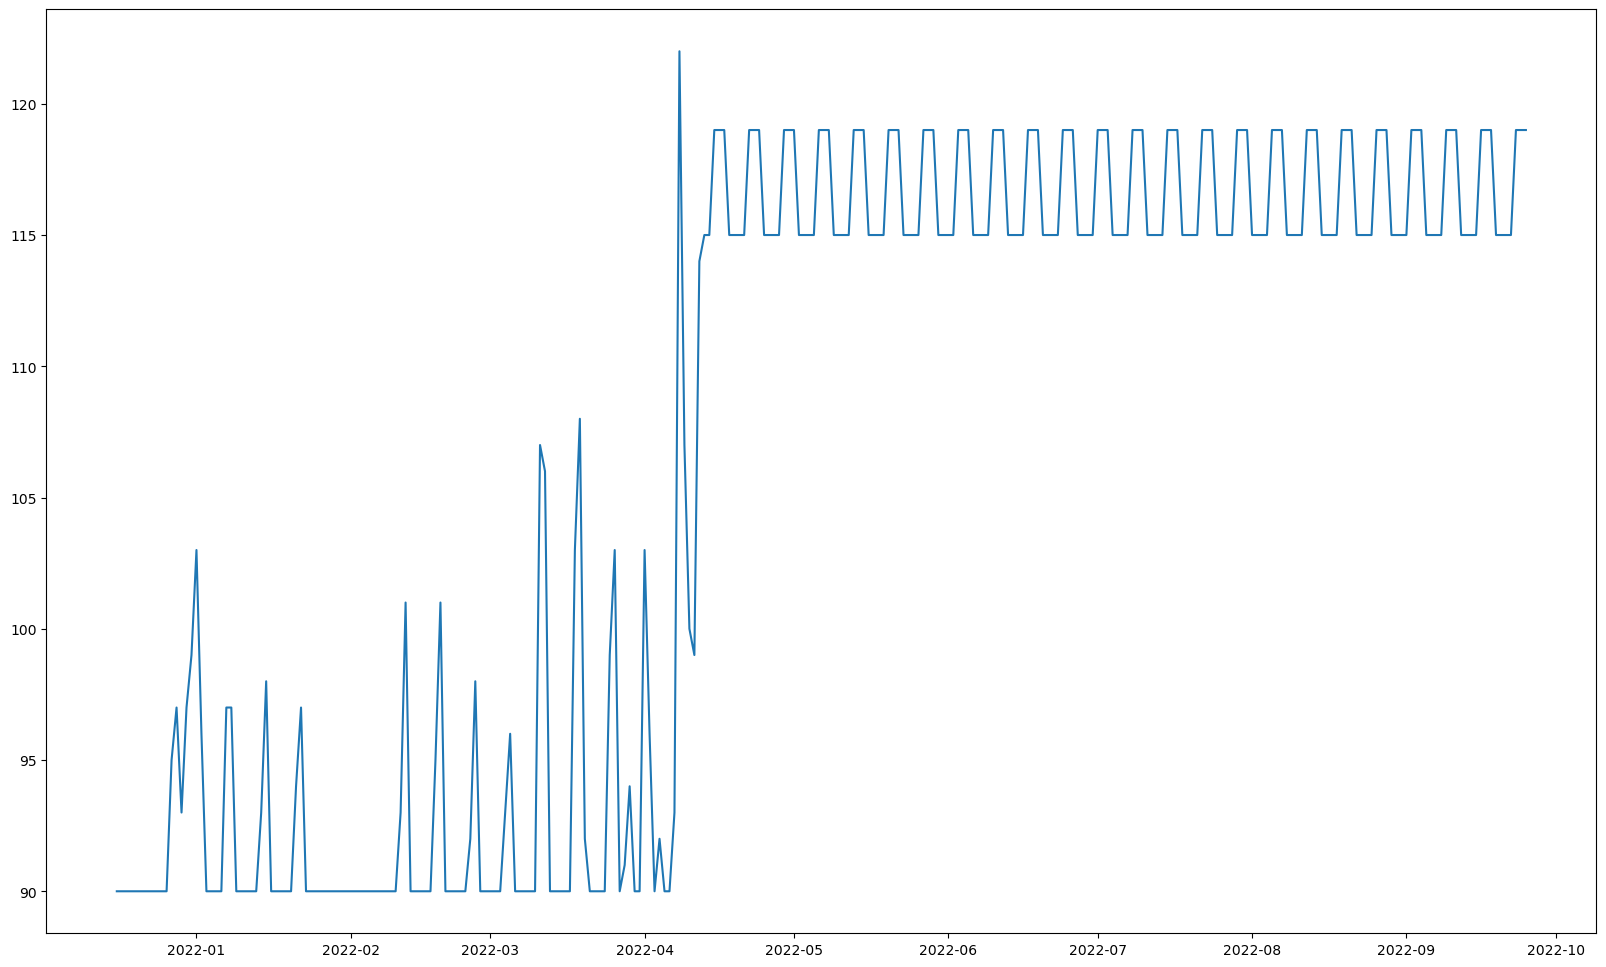

In [1261]:
graphing_one_bnb = asheville_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.show()

# fig = plt.figure()
# ax = plt.axes()

# ax.plot(x_graphing_one_bnb, y_graphing_one_bnb);

In [1262]:
asheville_modeling_data = asheville_data.drop(['listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
asheville_modeling_data.head()

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_biltmore,distance_to_downtown
0,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-15,"(35.6067, -82.55563)",4.52826,0.607702
1,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-16,"(35.6067, -82.55563)",4.52826,0.607702
2,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-17,"(35.6067, -82.55563)",4.52826,0.607702
3,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-18,"(35.6067, -82.55563)",4.52826,0.607702
4,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-19,"(35.6067, -82.55563)",4.52826,0.607702


In [1263]:
asheville_modeling_data['neighborhood'].value_counts()

Asheville    716942
Arden         42421
Woodfin       19710
Candler       17098
Fletcher      15256
Name: neighborhood, dtype: int64

In [1264]:
asheville_modeling_data['day_of_week'] = asheville_modeling_data['date'].dt.dayofweek
asheville_modeling_data['month'] = asheville_modeling_data['date'].dt.month
asheville_modeling_data['week'] = asheville_modeling_data['date'].dt.week
asheville_modeling_data = asheville_modeling_data.drop(['date'], axis = 1)
asheville_modeling_data.info()

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_11648/3433487010.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  asheville_modeling_data['week'] = asheville_modeling_data['date'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811427 entries, 0 to 811426
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   listing_id            811427 non-null  int64  
 1   host_is_superhost     811427 non-null  int64  
 2   room_type             811427 non-null  object 
 3   accommodates          811427 non-null  int64  
 4   bedrooms              811427 non-null  float64
 5   beds                  811427 non-null  float64
 6   neighborhood          811427 non-null  object 
 7   bathrooms             811427 non-null  float64
 8   Air conditioning      811427 non-null  int64  
 9   Wifi                  811427 non-null  int64  
 10  TV                    811427 non-null  int64  
 11  Kitchen               811427 non-null  int64  
 12  Washer                811427 non-null  int64  
 13  Dryer                 811427 non-null  int64  
 14  Heating               811427 non-null  int64  
 15  

In [1265]:
asheville_modeling_data['room_type'].value_counts()

Entire home/apt    693601
Private room       117826
Name: room_type, dtype: int64

In [1266]:
asheville_modeling_data['Heating'].value_counts()

1    688650
0    122777
Name: Heating, dtype: int64

In [1267]:
asheville_modeling_data.describe()

,listing_id,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
count,8.114270e+05,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000,811427.000000
mean,3.250005e+07,0.753548,4.442354,1.839915,2.378948,1.477150,0.868490,0.964566,0.878959,0.774608,0.561788,0.549746,0.848690,191.948523,4.676025,3.811705,2.994575,6.520620,26.540996
std,1.498932e+07,0.430945,2.596776,1.014856,1.542368,0.713593,0.337958,0.184874,0.326175,0.417840,0.496168,0.497519,0.358351,139.441946,1.567795,2.837848,1.998382,3.449343,15.044858
min,1.080610e+05,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.723008,0.043555,0.000000,1.000000,1.000000
25%,2.069282e+07,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,99.000000,3.544795,1.502541,1.000000,4.000000,13.000000
50%,3.461919e+07,1.000000,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,150.000000,4.338832,3.223016,3.000000,7.000000,27.000000
75%,4.588173e+07,1.000000,6.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,235.000000,5.818402,5.106344,5.000000,10.000000,40.000000
max,5.373538e+07,1.000000,16.000000,6.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,9.606803,13.208875,6.000000,12.000000,52.000000


In [1268]:
asheville_modeling_data

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Washer,Dryer,Heating,daily_price,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,...,1,1,1,120.0,"(35.6067, -82.55563)",4.528260,0.607702,2,12,50
1,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,...,1,1,1,120.0,"(35.6067, -82.55563)",4.528260,0.607702,3,12,50
2,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,...,1,1,1,120.0,"(35.6067, -82.55563)",4.528260,0.607702,4,12,50
3,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,...,1,1,1,120.0,"(35.6067, -82.55563)",4.528260,0.607702,5,12,50
4,108061,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,...,1,1,1,120.0,"(35.6067, -82.55563)",4.528260,0.607702,6,12,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,53735375,1,Entire home/apt,3,1.0,1.0,Asheville,1.0,1,1,...,0,0,0,165.0,"(35.5992, -82.63845)",6.301745,5.253736,5,12,49
811423,53735375,1,Entire home/apt,3,1.0,1.0,Asheville,1.0,1,1,...,0,0,0,150.0,"(35.5992, -82.63845)",6.301745,5.253736,6,12,49
811424,53735375,1,Entire home/apt,3,1.0,1.0,Asheville,1.0,1,1,...,0,0,0,150.0,"(35.5992, -82.63845)",6.301745,5.253736,0,12,50
811425,53735375,1,Entire home/apt,3,1.0,1.0,Asheville,1.0,1,1,...,0,0,0,150.0,"(35.5992, -82.63845)",6.301745,5.253736,1,12,50


In [1269]:
asheville_modeling_data.columns

Index(['listing_id', 'host_is_superhost', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'neighborhood', 'bathrooms', 'Air conditioning',
       'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating', 'daily_price',
       'coords', 'distance_to_biltmore', 'distance_to_downtown', 'day_of_week',
       'month', 'week'],
      dtype='object')

## Baseline Model - Neural Network

In [1270]:
#One hot encode the categorical columns
baseline_model_sklearn = asheville_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                              columns = ohe.get_feature_names_out())
baseline_model_cat_ohe

,neighborhood_Asheville,neighborhood_Candler,neighborhood_Fletcher,neighborhood_Woodfin,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
811425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [1271]:
#Merge the one hot encoded dataframe and the numeric columns
baseline_model_numeric = asheville_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'week']]

baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')
# baseline_model_comb_ohe = baseline_model_comb_ohe.groupby(['listing_id', 'week']).mean()
# baseline_model_comb_ohe = baseline_model_comb_ohe.reset_index()
# baseline_model_comb_ohe = baseline_model_comb_ohe.drop(['week'], axis = 1)
baseline_model_comb_ohe


,listing_id,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,53735375,165.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811423,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811424,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
811425,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [1272]:
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)

baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#### Instantiate a new scaler
scaler = StandardScaler()

baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

In [1273]:
#Consider adding a decaying learning rate

In [1274]:
#Instantiate a Regularizer

reg = l2(3e-3)

baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

Epoch 1/50
  1/586 [..............................] - ETA: 2:47 - loss: 190.3538 - mse: 53903.5352 - mae: 190.2736

2022-12-22 21:54:24.893163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 191.3351 - mse: 56077.4453 - mae: 191.2499

2022-12-22 21:54:29.048536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 5s 7ms/step - loss: 191.3351 - mse: 56077.4453 - mae: 191.2499 - val_loss: 189.8902 - val_mse: 55251.3750 - val_mae: 189.7951
Epoch 2/50
586/586 [==============================] - 4s 7ms/step - loss: 189.4633 - mse: 55347.9453 - mae: 189.3509 - val_loss: 187.8744 - val_mse: 54481.2578 - val_mae: 187.7406
Epoch 3/50
586/586 [==============================] - 4s 7ms/step - loss: 187.2454 - mse: 54519.1602 - mae: 187.0835 - val_loss: 185.4966 - val_mse: 53599.3789 - val_mae: 185.3038
Epoch 4/50
586/586 [==============================] - 4s 7ms/step - loss: 184.6891 - mse: 53586.1289 - mae: 184.4593 - val_loss: 182.7857 - val_mse: 52616.8320 - val_mae: 182.5163
Epoch 5/50
586/586 [==============================] - 4s 7ms/step - loss: 181.7674 - mse: 52542.2773 - mae: 181.4528 - val_loss: 179.6584 - val_mse: 51496.2148 - val_mae: 179.2954
Epoch 6/50
586/586 [==============================] - 4s 7ms/step - loss: 178.3693 - mse: 51345.8047 - mae: 177

Epoch 47/50
586/586 [==============================] - 4s 7ms/step - loss: 92.9447 - mse: 17904.0957 - mae: 90.3227 - val_loss: 73.5357 - val_mse: 13260.5801 - val_mae: 70.9328
Epoch 48/50
586/586 [==============================] - 4s 7ms/step - loss: 92.7060 - mse: 17869.0020 - mae: 90.1214 - val_loss: 73.3688 - val_mse: 13213.2305 - val_mae: 70.8038
Epoch 49/50
586/586 [==============================] - 4s 7ms/step - loss: 92.7373 - mse: 17865.0215 - mae: 90.1918 - val_loss: 73.2586 - val_mse: 13190.7422 - val_mae: 70.7322
Epoch 50/50
586/586 [==============================] - 4s 7ms/step - loss: 92.5358 - mse: 17816.4297 - mae: 90.0275 - val_loss: 73.1367 - val_mse: 13157.5469 - val_mae: 70.6483


In [1275]:
baseline_model_nn_results_train = baseline_model_nn.evaluate(baseline_model_X_train_scaled, 
                                                             baseline_model_y_train.values)
baseline_model_nn_results_test = baseline_model_nn.evaluate(baseline_model_X_test_scaled, 
                                                            baseline_model_y_test.values)

print(f'Baseline Model Neural Network Train Results: {baseline_model_nn_results_train}')
print(f'Baseline Model Neural Network Test Results: {baseline_model_nn_results_test}')

4565/4565 [==============================] - 20s 4ms/step - loss: 73.2265 - mse: 13191.7432 - mae: 70.7380
Baseline Model Neural Network Train Results: [73.30535125732422, 13246.2333984375, 70.81671905517578]
Baseline Model Neural Network Test Results: [73.22645568847656, 13191.7431640625, 70.73796844482422]


In [1276]:
baseline_model_nn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 86)                0         
                                                                 
 dense_33 (Dense)            (None, 16)                1392      
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [1277]:
baseline_model_nn_train_preds = baseline_model_nn.predict(baseline_model_X_train_scaled)
baseline_model_nn_test_preds = baseline_model_nn.predict(baseline_model_X_test_scaled)

2022-12-22 21:59:30.560951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


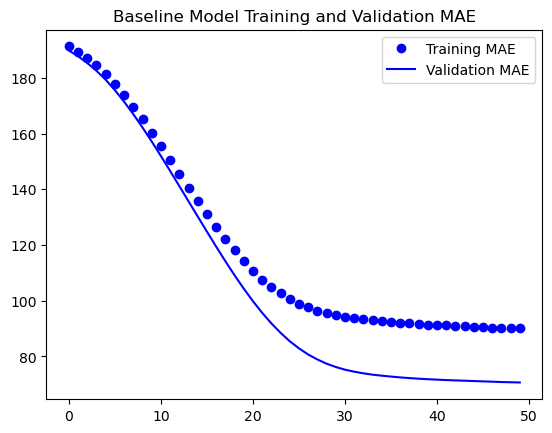

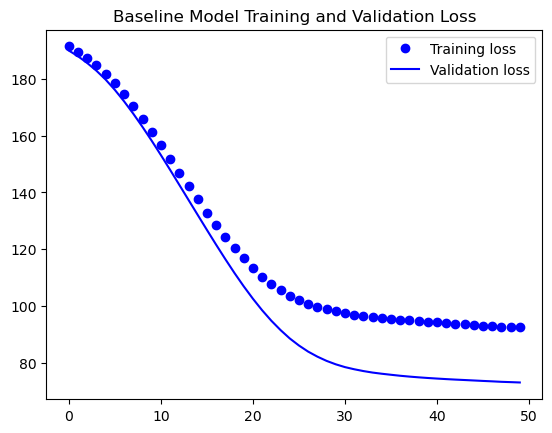

In [1278]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_mae = baseline_model_nn_histoire.history['mae']
baseline_model_val_mae = baseline_model_nn_histoire.history['val_mae']
baseline_model_loss = baseline_model_nn_histoire.history['loss']
baseline_model_val_loss = baseline_model_nn_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_mae))

plt.plot(baseline_model_epochs, baseline_model_mae, 'bo', label = 'Training MAE')
plt.plot(baseline_model_epochs, baseline_model_val_mae, 'b', label = 'Validation MAE')
plt.title('Baseline Model Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();

In [1279]:
print(f'Baseline Model train MAE w/ preds {mean_absolute_error(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model test MAE w/ preds {mean_absolute_error(baseline_model_y_test.values, baseline_model_nn_test_preds)}')

print(f'Baseline Model explained variance train score {explained_variance_score(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model explained variance test score {explained_variance_score(baseline_model_y_test.values, baseline_model_nn_test_preds)}')


print(f'Baseline Model test RMSE {mean_squared_error(baseline_model_y_test.values, baseline_model_nn_test_preds, squared = False)}')



Baseline Model train MAE w/ preds 70.81672591542777
Baseline Model test MAE w/ preds 70.7379902919072
Baseline Model explained variance train score 0.42233344228334935
Baseline Model explained variance test score 0.4229077797227053
Baseline Model test RMSE 114.85535324386477


## Model 2 - Neural Network

In [1280]:
#One hot encode the categorical columns
model2_sklearn = asheville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = asheville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_biltmore', 'distance_to_downtown']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

In [1281]:
#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [1282]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.025)

In [1283]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model
model2_nn = models.Sequential()
#Consider going bigger to smaller filters between conv1d layers
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
## model2_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
## model2_nn.add(layers.Dropout(0.3))
# model2_nn.add(layers.Dense(64, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
# model2_nn.add(layers.Dense(32, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
# model2_nn.add(layers.Dropout(0.3))
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)
early = [EarlyStopping(monitor='mae', min_delta = 0.001, patience = 20, mode = 'min'),
         ModelCheckpoint(filepath = 'asheville_model2.h5', monitor = 'mae', save_best_only = True),
         LearningRateScheduler(scheduler)]

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/120


2022-12-22 22:00:05.672798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 149.1691 - mse: 42521.3633 - mae: 149.0229

2022-12-22 22:00:18.898393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 14s 23ms/step - loss: 149.1691 - mse: 42521.3633 - mae: 149.0229 - val_loss: 105.5900 - val_mse: 27882.9160 - val_mae: 105.4045
Epoch 2/120
586/586 [==============================] - 12s 21ms/step - loss: 85.2314 - mse: 18895.4648 - mae: 85.0221 - val_loss: 74.3265 - val_mse: 14909.2725 - val_mae: 74.0988
Epoch 3/120
586/586 [==============================] - 12s 21ms/step - loss: 73.4793 - mse: 13666.6152 - mae: 73.2405 - val_loss: 68.2212 - val_mse: 12165.3057 - val_mae: 67.9744
Epoch 4/120
586/586 [==============================] - 12s 21ms/step - loss: 70.2030 - mse: 12247.6689 - mae: 69.9526 - val_loss: 66.3298 - val_mse: 11297.2217 - val_mae: 66.0767
Epoch 5/120
586/586 [==============================] - 12s 21ms/step - loss: 68.8915 - mse: 11765.3496 - mae: 68.6368 - val_loss: 65.3821 - val_mse: 10948.8281 - val_mae: 65.1258
Epoch 6/120
586/586 [==============================] - 12s 21ms/step - loss: 67.9292 - mse: 11471.5713 - mae: 67.

Epoch 47/120
586/586 [==============================] - 12s 21ms/step - loss: 59.9309 - mse: 8893.2861 - mae: 59.5714 - val_loss: 56.4201 - val_mse: 8186.3716 - val_mae: 56.0602
Epoch 48/120
586/586 [==============================] - 12s 21ms/step - loss: 59.8998 - mse: 8882.7256 - mae: 59.5396 - val_loss: 56.4182 - val_mse: 8326.0713 - val_mae: 56.0581
Epoch 49/120
586/586 [==============================] - 12s 21ms/step - loss: 59.7937 - mse: 8854.7129 - mae: 59.4331 - val_loss: 56.3069 - val_mse: 8186.7710 - val_mae: 55.9458
Epoch 50/120
586/586 [==============================] - 12s 21ms/step - loss: 59.7757 - mse: 8844.3652 - mae: 59.4143 - val_loss: 56.1866 - val_mse: 8178.4492 - val_mae: 55.8251
Epoch 51/120
586/586 [==============================] - 12s 21ms/step - loss: 59.6329 - mse: 8802.8691 - mae: 59.2710 - val_loss: 56.3059 - val_mse: 8047.4839 - val_mae: 55.9436
Epoch 52/120
586/586 [==============================] - 12s 21ms/step - loss: 59.6645 - mse: 8814.8164 - mae: 

586/586 [==============================] - 12s 21ms/step - loss: 58.2169 - mse: 8379.8701 - mae: 57.8481 - val_loss: 54.3834 - val_mse: 7546.7012 - val_mae: 54.0144
Epoch 94/120
586/586 [==============================] - 12s 21ms/step - loss: 58.1743 - mse: 8359.7100 - mae: 57.8054 - val_loss: 54.2557 - val_mse: 7569.6543 - val_mae: 53.8870
Epoch 95/120
586/586 [==============================] - 12s 21ms/step - loss: 58.1968 - mse: 8369.1035 - mae: 57.8281 - val_loss: 54.4028 - val_mse: 7460.7505 - val_mae: 54.0340
Epoch 96/120
586/586 [==============================] - 12s 21ms/step - loss: 58.0870 - mse: 8346.0029 - mae: 57.7182 - val_loss: 54.2373 - val_mse: 7448.0933 - val_mae: 53.8683
Epoch 97/120
586/586 [==============================] - 12s 21ms/step - loss: 58.1112 - mse: 8322.0039 - mae: 57.7423 - val_loss: 54.2032 - val_mse: 7502.2139 - val_mae: 53.8341
Epoch 98/120
586/586 [==============================] - 12s 21ms/step - loss: 58.1259 - mse: 8355.3438 - mae: 57.7568 - val

In [1284]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

4565/4565 [==============================] - 28s 6ms/step - loss: 53.3591 - mse: 7294.5928 - mae: 52.9858
Model 2 Neural Network Train Results: [53.36318588256836, 7295.19482421875, 52.98986053466797]
Model 2 Neural Network Test Results: [53.35906982421875, 7294.5927734375, 52.98582458496094]


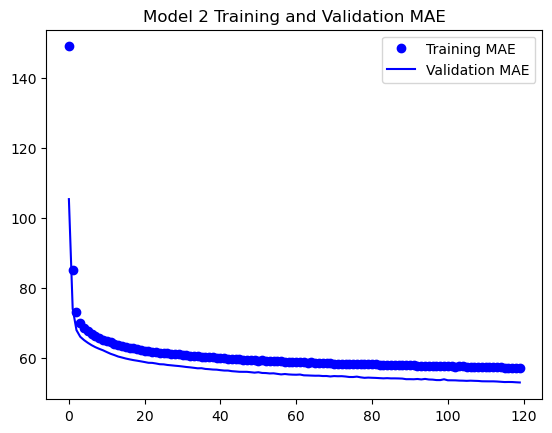

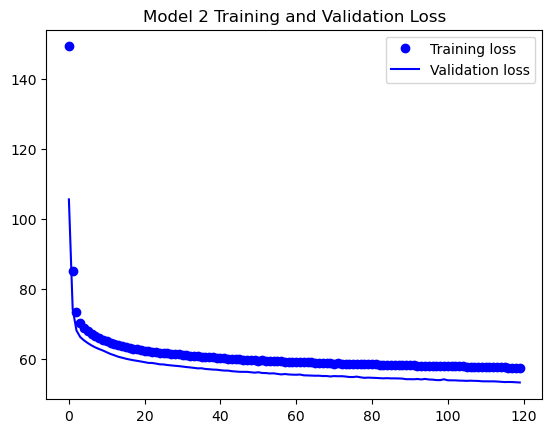

In [1285]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

In [1286]:
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2022-12-22 22:27:18.127940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [1287]:
print(f'Model 2 train MAE w/ preds {mean_absolute_error(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 test MAE w/ preds {mean_absolute_error(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 explained variance train score {explained_variance_score(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 explained variance test score {explained_variance_score(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 test RMSE {mean_squared_error(model2_y_test.values, model2_nn_test_preds, squared = False)}')

Model 2 train MAE w/ preds 52.98976052549849
Model 2 test MAE w/ preds 52.985676389912676
Model 2 explained variance train score 0.6342786929492084
Model 2 explained variance test score 0.6332034044807464
Model 2 test RMSE 85.40845416603489


In [1288]:
# best_model2_nn_model = load_model('asheville_model2.h5')
# best_model2_nn_y_test_pred = best_model2_nn_model.predict(model2_X_test_scaled)
# print(mean_squared_error(best_y_test_pred, y_test))
# print(mean_squared_error(best_y_test_pred, y_test, squared = False))
# print(mean_absolute_error(best_y_test_pred, y_test))

## Model 3 - Random Forest

In [1096]:
import time 

In [1289]:
%%time

model3_X = asheville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model3_y = asheville_modeling_data['daily_price']

model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model3_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)

CPU times: user 5min 59s, sys: 3.29 s, total: 6min 2s
Wall time: 6min 4s


Model 3 train accuracy 0.9967910137538337
Model 3 train MSE 7.900805978052868
Model 3 train MAE 1.8862425369671523


Model 3 test accuracy 0.9814995478845249
Model 3 test MSE 18.9498915289104
Model 3 test MAE 4.799439960793122


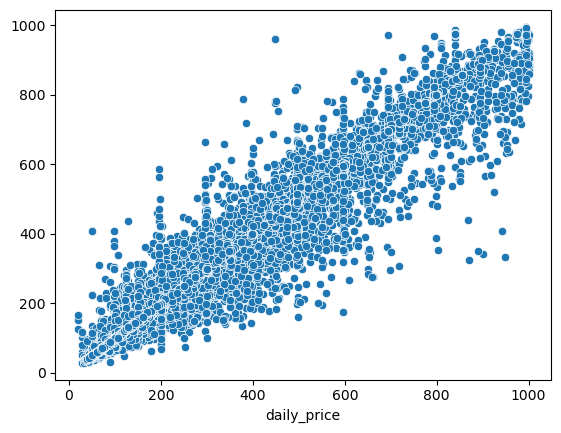

In [1290]:
model3_train_preds = model3_final_pipe.predict(model3_X_train)
model3_test_preds = model3_final_pipe.predict(model3_X_test)

print(f'Model 3 train accuracy {model3_final_pipe.score(model3_X_train, model3_y_train)}')
print(f'Model 3 train MSE {mean_squared_error(model3_y_train, model3_train_preds, squared = False)}')
print(f'Model 3 train MAE {mean_absolute_error(model3_y_train, model3_train_preds)}')
print(f'\n')
print(f'Model 3 test accuracy {model3_final_pipe.score(model3_X_test, model3_y_test)}')
print(f'Model 3 test MSE {mean_squared_error(model3_y_test, model3_test_preds, squared = False)}')
print(f'Model 3 test MAE {mean_absolute_error(model3_y_test, model3_test_preds)}')

sns.scatterplot(y = model3_test_preds, x = model3_y_test);

In [1291]:
model3_coeffs = dict(zip(model3_final_pipe['preprocess'].get_feature_names_out(), 
                                 model3_final_pipe['model'].feature_importances_))
model3_coeffs = sorted(model3_coeffs.items(), key = lambda x:x[1])
model3_coeffs

[('nominalpipe__week_33', 5.860196749173842e-05),
 ('nominalpipe__week_38', 6.255313247445561e-05),
 ('nominalpipe__week_32', 6.876546286755099e-05),
 ('nominalpipe__week_30', 7.085170962710308e-05),
 ('nominalpipe__week_12', 7.29060698307896e-05),
 ('nominalpipe__week_24', 7.292924405100366e-05),
 ('nominalpipe__week_43', 7.337908121082068e-05),
 ('nominalpipe__week_18', 8.045901313637438e-05),
 ('nominalpipe__week_19', 8.632511984765911e-05),
 ('nominalpipe__week_29', 8.914060514442776e-05),
 ('nominalpipe__week_28', 9.259940052486722e-05),
 ('nominalpipe__week_34', 9.727773581880003e-05),
 ('nominalpipe__week_37', 0.00010359184619699),
 ('nominalpipe__week_17', 0.0001083491050587779),
 ('nominalpipe__week_20', 0.0001114193585113515),
 ('nominalpipe__week_44', 0.00011811489415621175),
 ('nominalpipe__week_39', 0.00012058046672176467),
 ('nominalpipe__week_8', 0.00012810976752182157),
 ('nominalpipe__week_45', 0.00013307433039606568),
 ('nominalpipe__week_10', 0.00013329253139712422),

In [1100]:
# text = input()